In [69]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import agg, data, fl, log, nn, plot, poison, resnet, sim, wandb
from cfgs.fedargs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
project = 'fl-shap'
name = 'fedavg-cnn-mnist'

#Define Custom CFGs
fedargs.num_clients = 10
mal_clients = [c for c in range(5)]
shap_explain["is"] = True

# Save Logs To File (info | debug | warning | error | critical) [optional]
log.init("info")
wb = wandb.init(name, project)

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [71]:
# Device settings
use_cuda = fedargs.cuda and torch.cuda.is_available()
torch.manual_seed(fedargs.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [72]:
# Prepare clients
host = socket.gethostname()
clients = [host + "(" + str(client + 1) + ")" for client in range(fedargs.num_clients)]

In [73]:
# Initialize Global and Client models
global_model = copy.deepcopy(fedargs.model)
# Load Data to clients
train_data, test_data = data.load_dataset(fedargs.dataset, only_to_tensor = True)

In [74]:
clients_data = data.split_data(train_data, clients)

<h1>SHAP: Trim Data For Class Sniffing</h1>

In [75]:
if shap_explain["is"]:
    for client in mal_clients:
        clients_data[clients[client]] = shap_explain["trim_data"](clients_data[clients[client]], shap_explain["trim_labels"])    

In [76]:
client_train_loaders, _ = data.load_client_data(clients_data, fedargs.client_batch_size, None, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=fedargs.test_batch_size, shuffle=True, **kwargs)

client_details = {
        client: {"train_loader": client_train_loaders[client],
                 "model": copy.deepcopy(global_model),
                 "model_update": None}
        for client in clients
    }

In [77]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped

@background
def process(client, epoch, model, train_loader, fedargs, device):
    # Train
    model_update, model, loss = fedargs.train_func(model, train_loader, 
                                                   fedargs.learning_rate,
                                                   fedargs.weight_decay,
                                                   fedargs.local_rounds, device)

    log.jsondebug(loss, "Epoch {} of {} : Federated Training loss, Client {}".format(epoch, fedargs.epochs, client))
    log.modeldebug(model_update, "Epoch {} of {} : Client {} Update".format(epoch, fedargs.epochs, client))
    
    return model_update, model

In [78]:
import time
start_time = time.time()

fedargs.epochs = 2
    
# Federated Training
for epoch in tqdm(range(fedargs.epochs)):
    log.info("Federated Training Epoch {} of {}".format(epoch, fedargs.epochs))
    '''
    # Global Model Update
    if epoch > 0:     
        # Average
        global_model = fl.federated_avg(client_model_updates, global_model)
        log.modeldebug(global_model, "Epoch {} of {} : Server Update".format(epoch, fedargs.epochs))
        
        # Test and Log
        global_test_output = fedargs.eval_func(global_model, test_loader, device)
        wb.log({"epoch": epoch, "time": time.time(), "acc": global_test_output["accuracy"], "loss": global_test_output["test_loss"]})
        log.jsoninfo(global_test_output, "Global Test Outut after Epoch {} of {}".format(epoch, fedargs.epochs))
        
        # Update client models
        for client in clients:
            client_details[client]['model'] = copy.deepcopy(global_model)
    '''
    # Clients
    tasks = [process(client, epoch, client_details[client]['model'],
                     client_details[client]['train_loader'],
                     fedargs, device) for client in clients]
    try:
        updates = fedargs.loop.run_until_complete(asyncio.gather(*tasks))
    except KeyboardInterrupt as e:
        log.error("Caught keyboard interrupt. Canceling tasks...")
        tasks.cancel()
        fedargs.loop.run_forever()
        tasks.exception()

    for client, (model_update, model) in zip(clients, updates):
        client_details[client]['model_update'], client_details[client]['model'] = model_update, model
    client_model_updates = {client: details["model_update"] for client, details in client_details.items()}

print(time.time() - start_time)

100%|██████████| 2/2 [00:58<00:00, 29.30s/it]

58.60203671455383


<h1>SHAP Explain</h1>

In [79]:
print(clients[0])
print(fedargs.eval_func(client_details['bladecluster.iitp.org(1)']['model'], test_loader, device))

bladecluster.iitp.org(1)
{'test_loss': 2.0114392253875732, 'correct': 7134, 'accuracy': 71.34}


In [80]:
batch = next(iter(test_loader))
images, labels = batch
baseline = images
    
explain1 = shap.DeepExplainer(client_details['bladecluster.iitp.org(1)']['model'], baseline)
explain2 = shap.DeepExplainer(client_details['bladecluster.iitp.org(9)']['model'], baseline)
explain3 = shap.DeepExplainer(global_model, baseline)
#explain = shap.DeepExplainer(global_model, baseline)

tensor(1)
tensor(4)


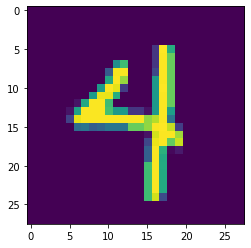

In [81]:
label = -1
while label != 4:
    batch = next(iter(test_loader))
    images, labels = batch
    g_img, label = images[0], labels[0]
    plt.imshow(g_img.numpy().squeeze())
    print(label)

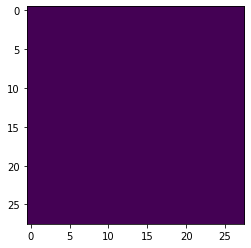

In [82]:
z_img = torch.tensor([[0.0 for col in range(28)] for row in range(28)])
z_img = z_img.reshape(1,28,28)
plt.imshow(z_img.numpy().squeeze())

In [83]:
def shap_plot(explain, img):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(10):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(784).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)

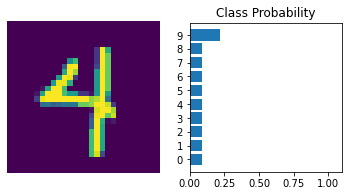

In [84]:
from torch.nn import functional as F

def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze()    
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    
model = client_details['bladecluster.iitp.org(5)']['model']
with torch.no_grad():
    logits = model.forward(g_img.unsqueeze(0).float())

ps = F.softmax(logits, dim=1)
_, label = torch.max(ps, 1)
view_classify(g_img, ps)

shap_sum 0.0034583163732245376
shap_sum 0.021520737399016776
shap_sum 0.020846803907918154
shap_sum 0.11223088075085563
shap_sum 0.00015201218977710157
shap_sum 1.0503460951538468
shap_sum 0.052379383419834
shap_sum 0.08036416203208718
shap_sum 0.10314427956762962
shap_sum 0.7246992177733205


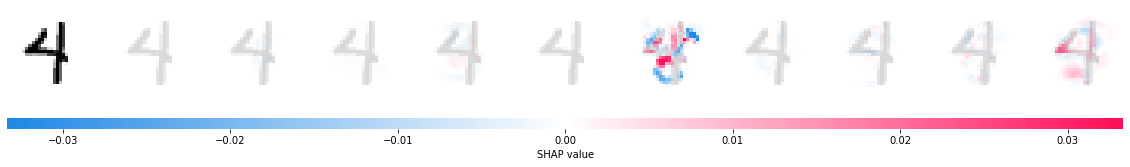

In [85]:
shap_plot(explain1, g_img)

shap_sum 0.0330410104165067
shap_sum 0.004733292854710185
shap_sum 0.012496377775286283
shap_sum 0.034696748882316095
shap_sum 0.6907656072908139
shap_sum 0.21658425727661257
shap_sum 0.06248333744809531
shap_sum 0.05777881287556219
shap_sum 0.029881386392907106
shap_sum 3.454227045598481


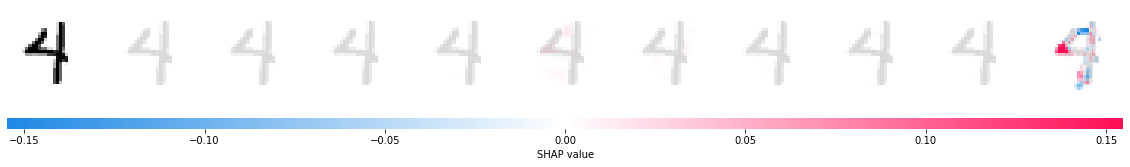

In [86]:
shap_plot(explain2, g_img)

shap_sum 0.03287667839154906
shap_sum 0.5665607875992009
shap_sum 0.3029916374489723
shap_sum 0.1324204935340525
shap_sum 0.00990878177192328
shap_sum 0.08964821561944802
shap_sum 0.8143943597494712
shap_sum 0.6063034225673931
shap_sum 0.01958037566717491
shap_sum 0.044668953742899475


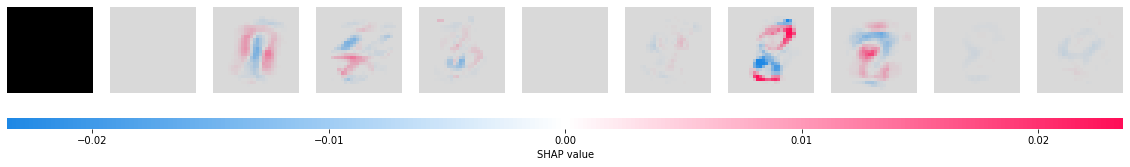

In [87]:
shap_plot(explain1, z_img)

shap_sum 0.2842002410532132
shap_sum 0.3949077267392308
shap_sum 0.6074973357108213
shap_sum 0.025772794552567646
shap_sum 0.19913673857232084
shap_sum 0.16582385444499437
shap_sum 0.8955887741924116
shap_sum 0.3168670439964991
shap_sum 0.02448179289548405
shap_sum 0.32811190652228994


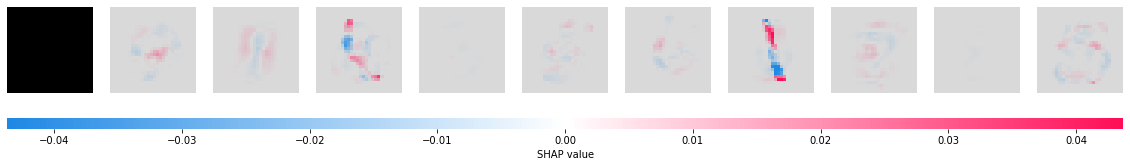

In [88]:
shap_plot(explain2, z_img)

<h1> End </h1>